# Bitcoin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import plotly.graph_objects as go
from colorama import Fore
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model


#### Having a look at our data

In [623]:
# bitcoin = pd.read_csv('bitcoin_original.csv')
# bitcoin = bitcoin.drop(columns=['Unnamed: 0'])
# for name in bitcoin.columns[1:-2]:
#     bitcoin[name] = bitcoin[name].str.replace(',', '').astype(float)
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# bitcoin = bitcoin.sort_values('Date')
# bitcoin['Average'] = (bitcoin['High'] + bitcoin['Low']) / 2
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
# bitcoin.head()

In [2]:
bitcoin_data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'])

In [3]:
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1


In [4]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5282 non-null   datetime64[ns]
 1   Price     5282 non-null   float64       
 2   Open      5282 non-null   float64       
 3   High      5282 non-null   float64       
 4   Low       5282 non-null   float64       
 5   Vol.      5276 non-null   object        
 6   Change %  5282 non-null   object        
 7   Average   5282 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 330.2+ KB


In [5]:
bitcoin_data.describe()

,Date,Price,Open,High,Low,Average
count,5282,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,2017-10-09 12:00:00,13991.793601,13973.960621,14301.911473,13630.541746,13966.226609
min,2010-07-18 00:00:00,0.100000,0.000000,0.100000,0.000000,0.050000
25%,2014-02-27 06:00:00,236.325000,236.225000,240.300000,232.325000,236.250000
50%,2017-10-09 12:00:00,3694.250000,3688.400000,3826.400000,3611.800000,3727.825000
75%,2021-05-21 18:00:00,20759.675000,20725.975000,21307.025000,20256.025000,20796.437500
max,2025-01-01 00:00:00,106138.900000,106140.700000,108244.900000,105350.600000,106797.750000
std,NaN,20663.596560,20634.796513,21096.208461,20162.686270,20626.123003


In [6]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
Average     0
dtype: int64

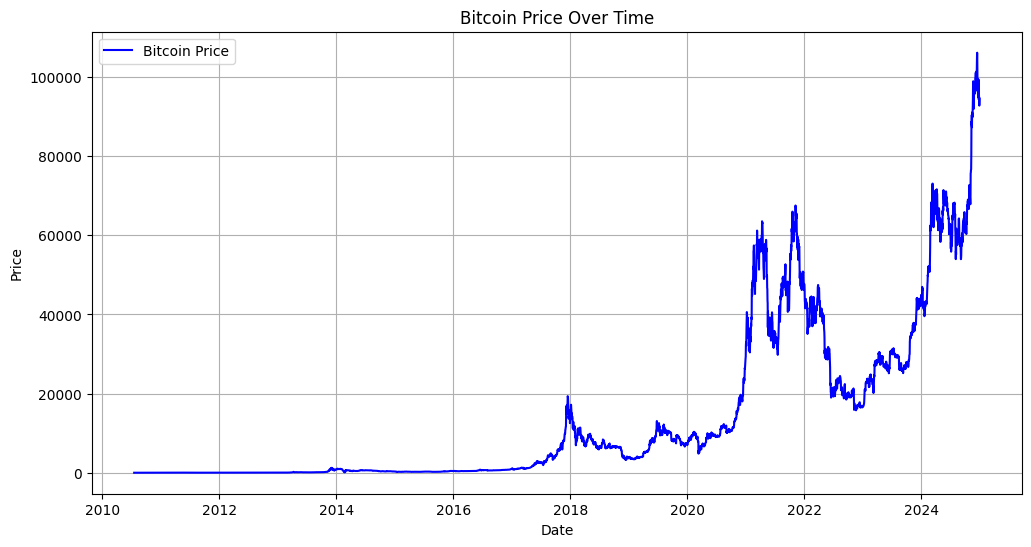

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data['Date'], bitcoin_data['Price'], label='Bitcoin Price', color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Graphing Bitcoin Halving events

When Is the Next Bitcoin Halving?

Nov. 28, 2012, to 25 bitcoins.

July 9, 2016, to 12.5 bitcoins.

May 11, 2020, to 6.25 bitcoins.

April 19, 2024, to 3.125 bitcoins.

<figure>
  <img src="data/bitcoin/bitcoin_halving.webp" alt="Bitcoin Halving" width="600">
  <figcaption>Source: [Bitcoin Halving: What It Is and Why It Matters for Crypto Investors](https://www.investopedia.com/bitcoin-halving-4843769)</figcaption>
</figure>


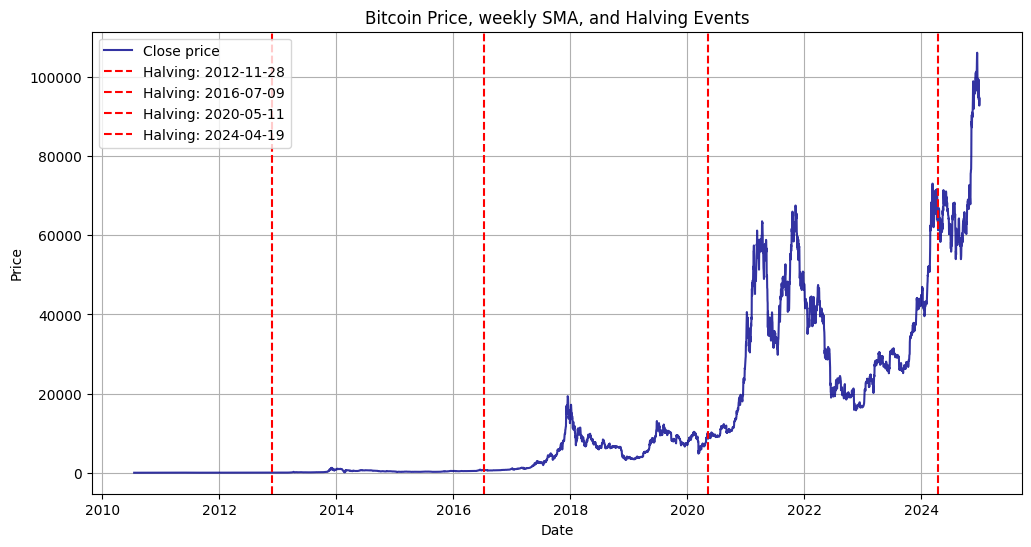

In [8]:
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-19'])
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)

for halving_date in halving_dates:
    plt.axvline(x=halving_date, color='red', linestyle='--', label=f'Halving: {halving_date.strftime("%Y-%m-%d")}')
plt.title('Bitcoin Price, weekly SMA, and Halving Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [9]:
bitcoin_data['year'] = bitcoin_data['Date'].dt.year
bitcoin_data['month'] = bitcoin_data['Date'].dt.month
bitcoin_data['day'] = bitcoin_data['Date'].dt.day

bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average,year,month,day
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1,2010,7,18
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1,2010,7,19
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1,2010,7,20
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1,2010,7,21
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1,2010,7,22


In [10]:
bitcoin_data.drop(columns=['Vol.', 'Change %'], inplace=True)
bitcoin_data.head()

,Date,Price,Open,High,Low,Average,year,month,day
0,2010-07-18,0.1,0.0,0.1,0.1,0.1,2010,7,18
1,2010-07-19,0.1,0.1,0.1,0.1,0.1,2010,7,19
2,2010-07-20,0.1,0.1,0.1,0.1,0.1,2010,7,20
3,2010-07-21,0.1,0.1,0.1,0.1,0.1,2010,7,21
4,2010-07-22,0.1,0.1,0.1,0.1,0.1,2010,7,22


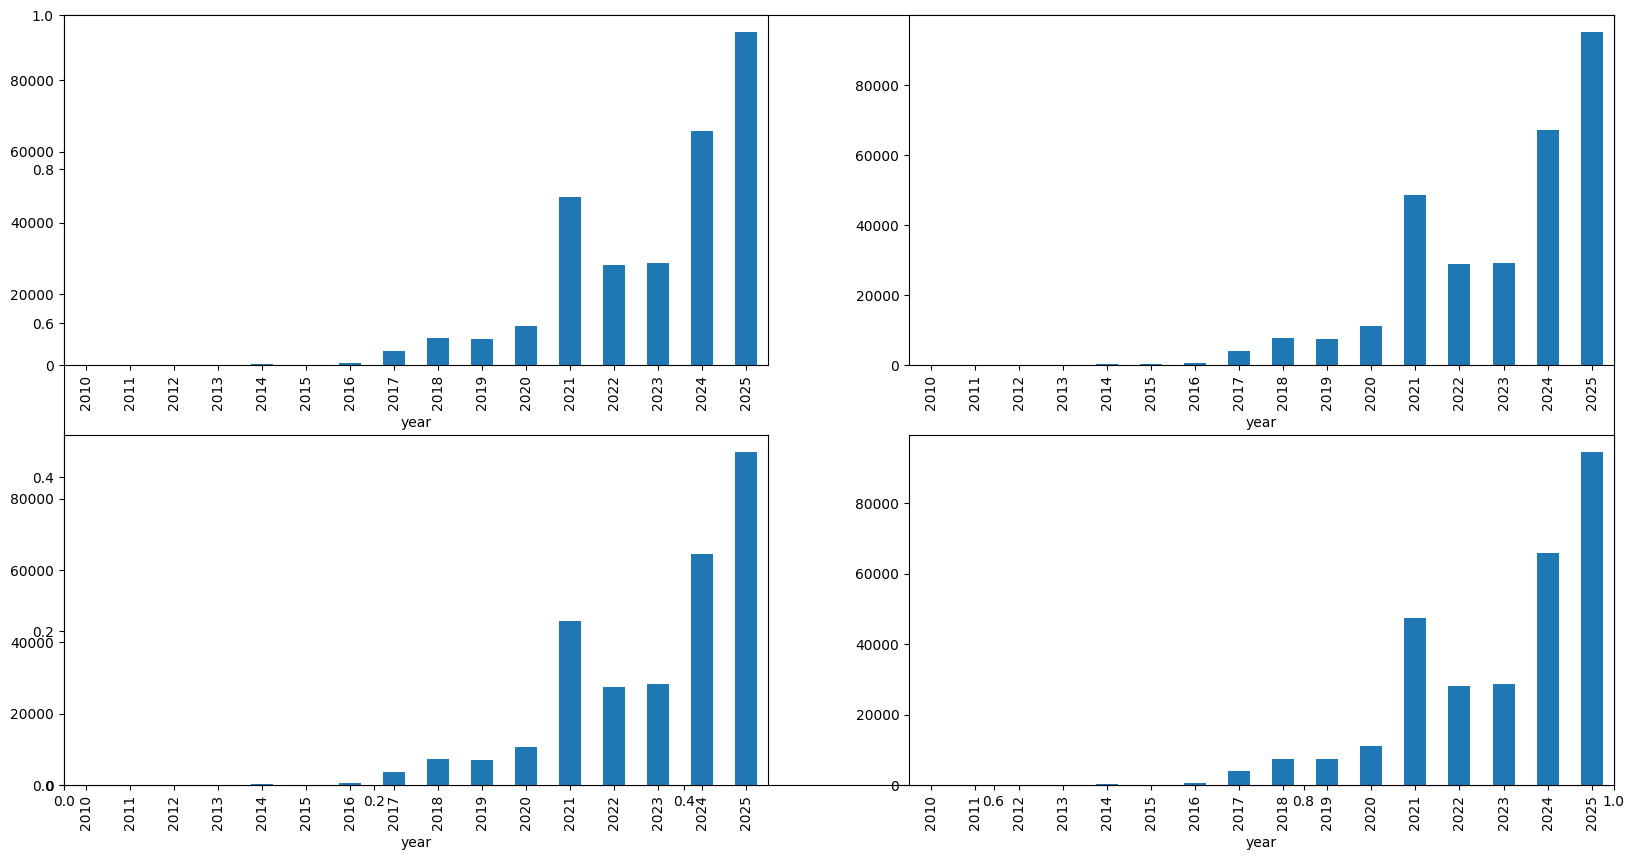

In [11]:
data_grouped = bitcoin_data.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Price']):
    plt.subplot(2, 2, i + 1)
    data_grouped[col].plot.bar()
plt.show()

<span style="font-size: 32px; font-weight: bold;">!!!!!!!!!!!!! From now on we are only using data from 2016 onwards !!!!!!!!!!!!!</span>


In [12]:
bitcoin_data.columns


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Average', 'year', 'month',
       'day'],
      dtype='object')

In [13]:
columns_to_drop = ['Open', 'High', 'Low', 'Average', 'year', 'month', 'day']
bitcoin = bitcoin_data.drop(columns=columns_to_drop)
bitcoin = bitcoin[bitcoin['Date'] >= '2016-01-01']
bitcoin = bitcoin.set_index('Date')
bitcoin

,Price
Date,
2016-01-01,434.0
2016-01-02,433.7
2016-01-03,430.7
2016-01-04,433.3
2016-01-05,431.2
...,...
2024-12-28,95284.5
2024-12-29,93716.3
2024-12-30,92779.8


#### Stationarity check - Augmented Dickey–Fuller test and seasonality checks

In [14]:
adf_test = adfuller(bitcoin['Price'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: -0.029257087001064667
p-value: 0.9560446238021381
Critical values: {'1%': np.float64(-3.4323581184837426), '5%': np.float64(-2.862427266935068), '10%': np.float64(-2.5672423111140947)}
Fail to reject the null hypothesis - series is non-stationary


#### Why Create `Close_Diff`, `Close_Log`, and `Close_Log_Diff` columns?

When analyzing and modeling non-stationary time series data, such as Bitcoin prices, it is important to transform the data into a stationary form. Stationarity means that the statistical properties of the series (mean, variance) do not change over time, which is a key assumption for many time series models. We create the following three columns to address this:

1. `Close_Diff` (Differencing)
- **Purpose**: To stabilize the mean of the series by removing trends.
- **Explanation**: Differencing subtracts each data point from the previous one, helping to eliminate trends and making the series stationary. This is essential for models that require constant mean and variance over time.

2. `Close_Log` (Logging)
- **Purpose**: To stabilize the variance of the series.
- **Explanation**: Logging reduces the impact of large fluctuations by compressing the scale of the data. This is especially useful when the series exhibits exponential growth or large spikes, as it makes the data more consistent and easier to analyze.

3. `Close_Log_Diff` (Logging followed by Differencing)
- **Purpose**: To handle both non-stationary mean and variance simultaneously.
- **Explanation**: Logging is applied first to stabilize the variance, followed by differencing to stabilize the mean. This combination ensures the series meets the stationarity requirements, making it suitable for decomposition and predictive modeling.

Importance of These Transformations
- **Stationarity Requirement**: Many time series models, such as ARIMA, assume that the data is stationary. These transformations help meet that requirement, ensuring the models can accurately capture and predict patterns in the data.
- **Component Separation**: By transforming the series, we can more effectively separate the trend, seasonal, and residual components, leading to a clearer understanding of the underlying patterns.
- **Improved Model Accuracy**: Stationary series often result in more reliable and accurate models, as they align better with the assumptions of common time series analysis techniques.

#### Creating new columns

In [15]:
bitcoin['Close_Diff'] = bitcoin['Price'].diff()
bitcoin['Close_Log'] = np.log(bitcoin['Price'])
bitcoin['Close_Log_Diff'] = bitcoin['Close_Log'].diff()

In [16]:
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-01,434.0,NaN,6.073045,NaN
2016-01-02,433.7,-0.3,6.072353,-0.000691
2016-01-03,430.7,-3.0,6.065412,-0.006941
2016-01-04,433.3,2.6,6.071430,0.006019
2016-01-05,431.2,-2.1,6.066572,-0.004858


Drop the NaN values created by differencing

In [17]:
bitcoin.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691
2016-01-03,430.7,-3.0,6.065412,-0.006941
2016-01-04,433.3,2.6,6.071430,0.006019
2016-01-05,431.2,-2.1,6.066572,-0.004858
2016-01-06,430.8,-0.4,6.065644,-0.000928


In [18]:
bitcoin.tail()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2024-12-28,95284.5,1008.6,11.464622,0.010642
2024-12-29,93716.3,-1568.2,11.448027,-0.016595
2024-12-30,92779.8,-936.5,11.437984,-0.010043
2024-12-31,93557.2,777.4,11.446328,0.008344
2025-01-01,94560.2,1003.0,11.456992,0.010664


In [19]:
series_list = {
    'Close_Diff': bitcoin['Close_Diff'],
    'Close_Log': bitcoin['Close_Log'],
    'Close_Log_Diff': bitcoin['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 2.3136336478386594e-15
Close_Log is non-stationary, with p-value: 0.4834741731268842
Close_Log_Diff is stationary, with p-value: 0.0


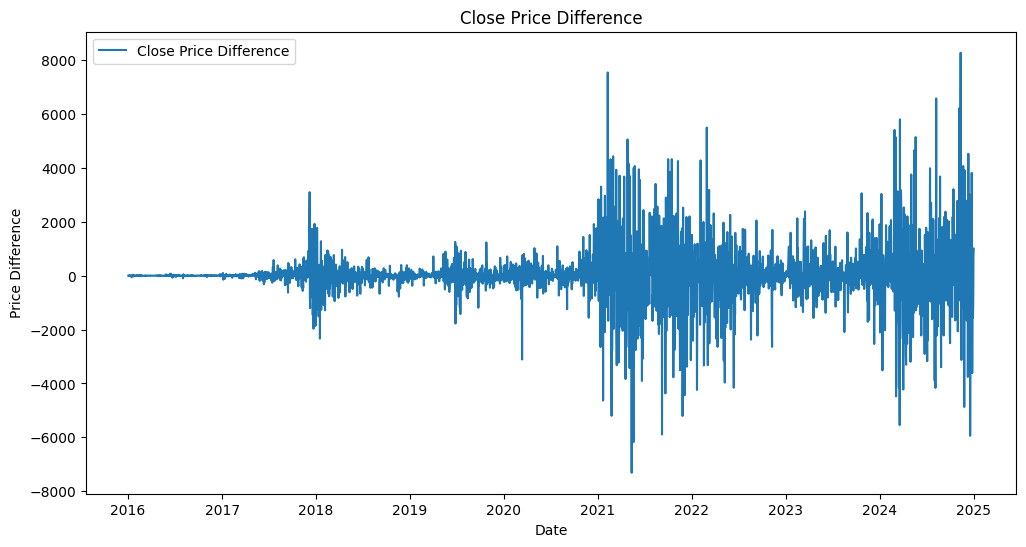

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Diff'], label='Close Price Difference')
plt.title('Close Price Difference')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

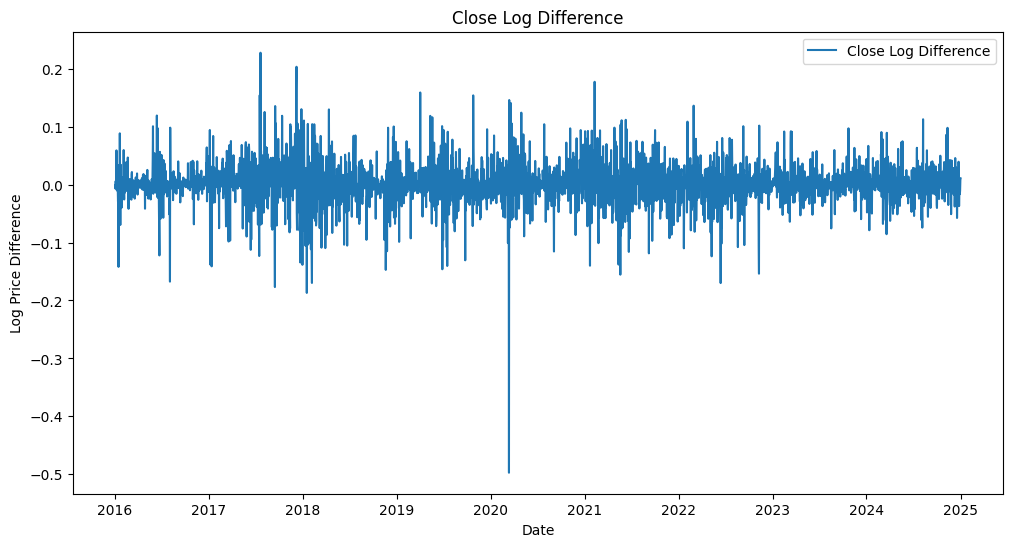

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log_Diff'], label='Close Log Difference')
plt.title('Close Log Difference')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')
plt.legend()
plt.show()

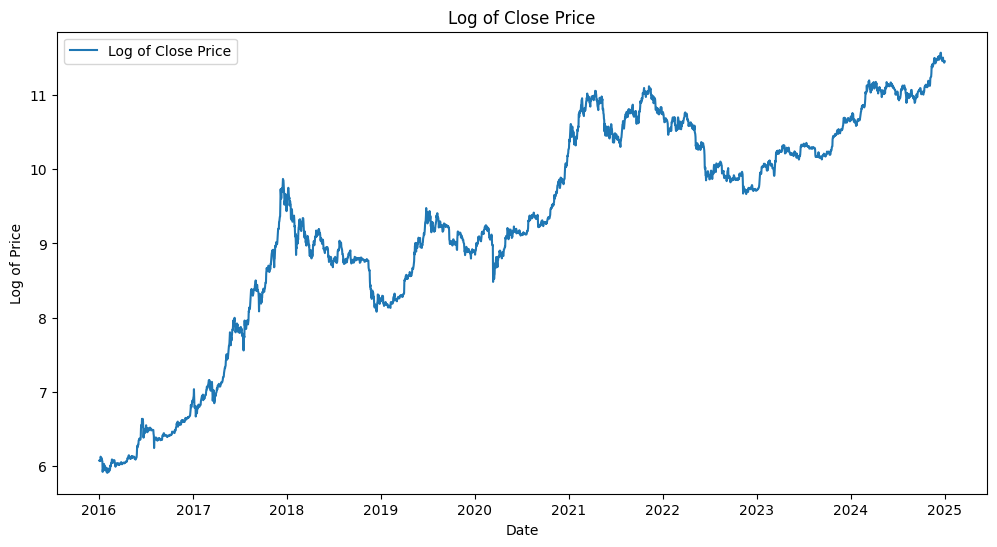

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

#### Plotting frequency

In [23]:
df_monthly = bitcoin.resample('ME').mean()
df_annual = bitcoin.resample('YE').mean()
df_quarterly = bitcoin.resample('QE').mean()

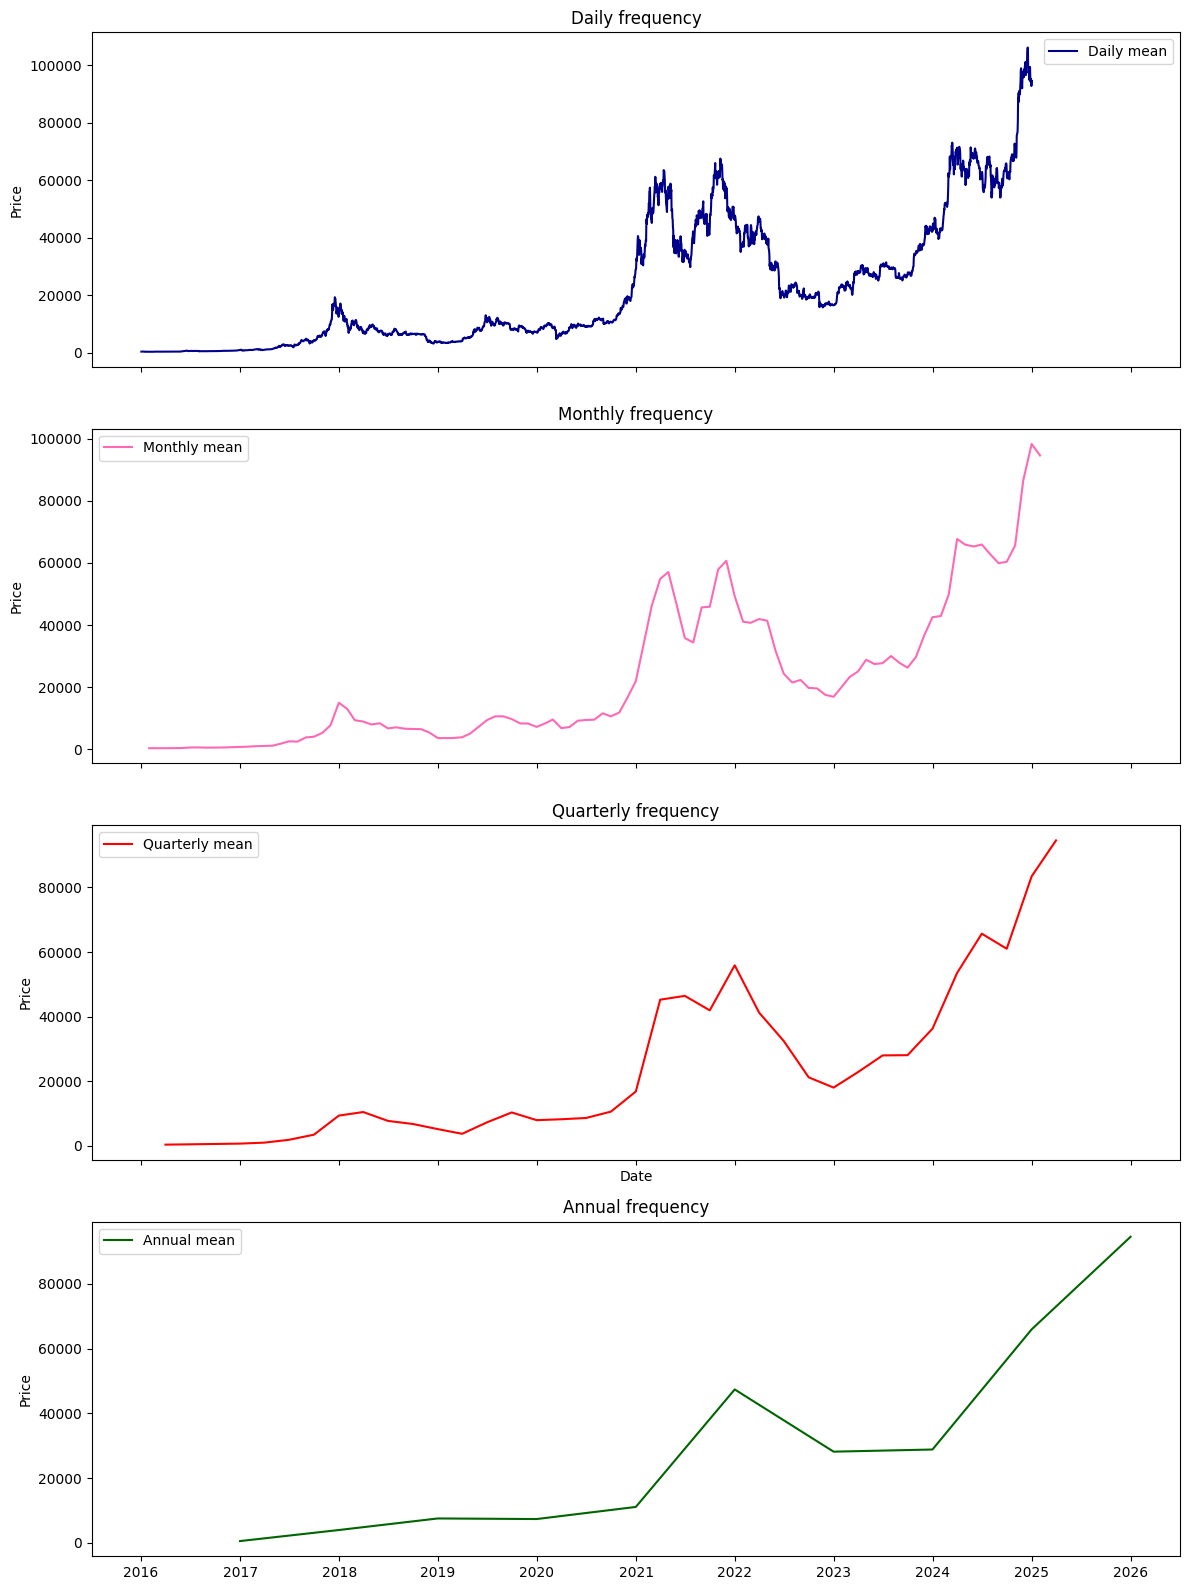

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(bitcoin.index, bitcoin['Price'], label='Daily mean', color='darkblue')
axs[0].set_title('Daily frequency')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df_monthly.index, df_monthly['Price'], label='Monthly mean', color='hotpink')
axs[1].set_title('Monthly frequency')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(df_quarterly.index, df_quarterly['Price'], label='Quarterly mean', color='red')
axs[2].set_title('Quarterly frequency')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()

axs[3].plot(df_annual.index, df_annual['Price'], label='Annual mean', color='darkgreen')
axs[3].set_title('Annual frequency')
axs[3].set_ylabel('Price')
axs[3].legend()

plt.tight_layout()
plt.show()

#### Moving Average

In [25]:
bitcoin['SMA_7'] = bitcoin['Price'].rolling(window=7).mean()
bitcoin_data['SMA_7'] = bitcoin_data['Price'].rolling(window=7).mean()
bitcoin.head(15)


,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7
Date,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN
2016-01-07,457.0,26.2,6.124683,0.059039,NaN
2016-01-08,452.9,-4.1,6.115671,-0.009012,438.514286
2016-01-09,448.3,-4.6,6.105463,-0.010209,440.600000
2016-01-10,446.2,-2.1,6.100767,-0.004695,442.814286


In [26]:
bitcoin.tail()


,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7
Date,,,,,
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714
2024-12-31,93557.2,777.4,11.446328,0.008344,94968.957143
2025-01-01,94560.2,1003.0,11.456992,0.010664,94278.800000


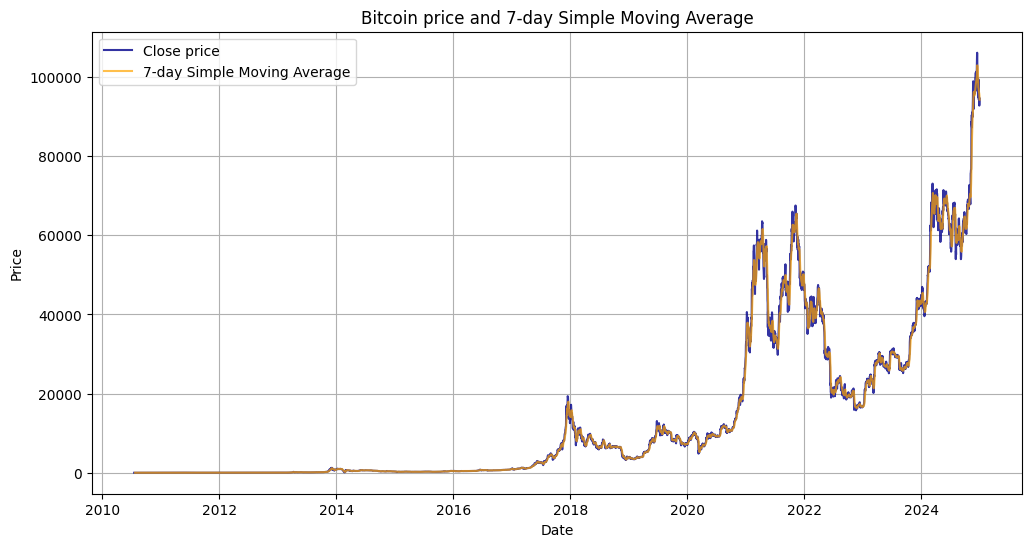

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data["Date"], bitcoin_data['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


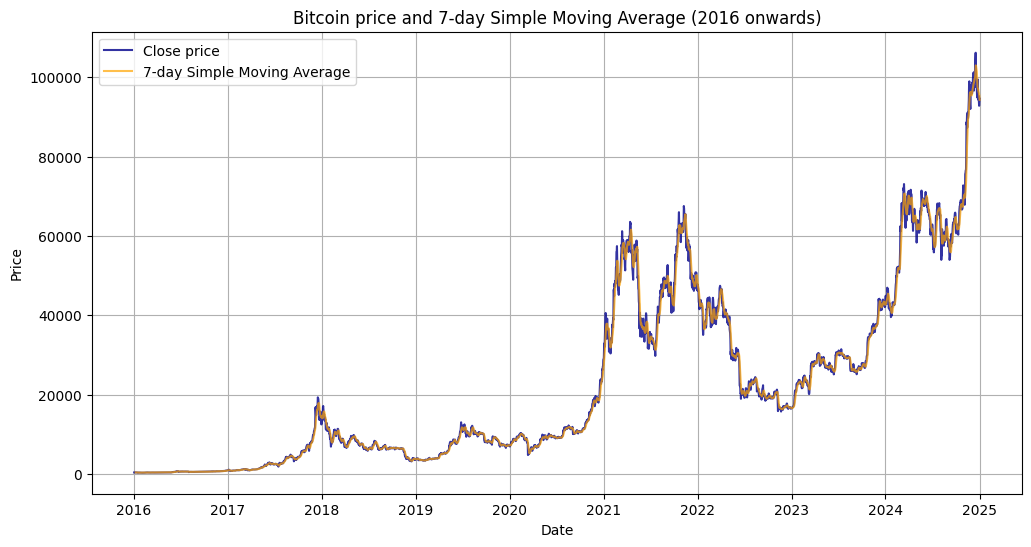

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average (2016 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

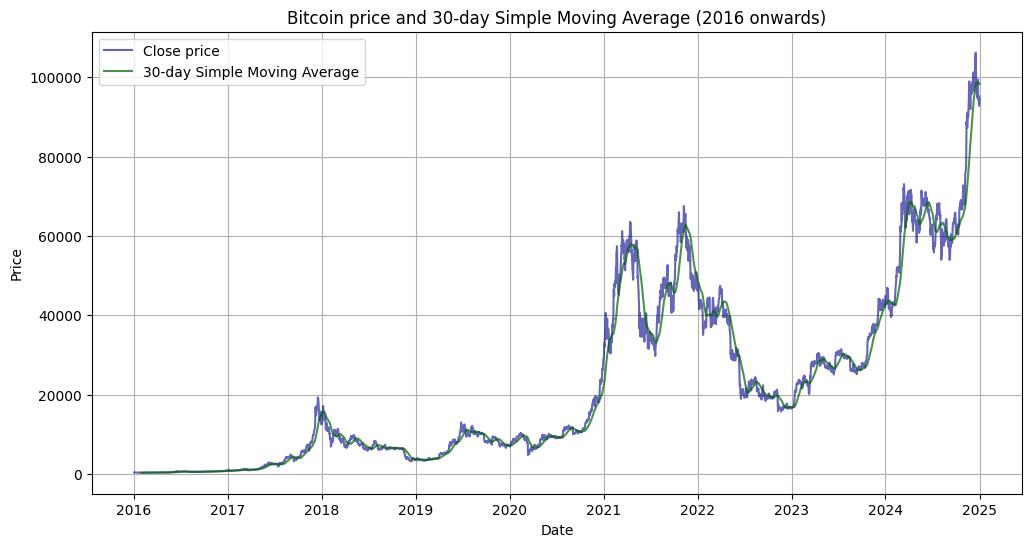

In [29]:
bitcoin['SMA_30'] = bitcoin['Price'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Price"], label='Close price', color='darkblue', alpha=0.6)
plt.plot(bitcoin['SMA_30'], label='30-day Simple Moving Average', color='darkgreen', alpha=0.7)
plt.title('Bitcoin price and 30-day Simple Moving Average (2016 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Plotting decompositions

1. **Original Time Series: Multiplicative Decomposition**
- **Reason**: The original series is non-stationary (due to trends and high volatility). 
- **Why Multiplicative?**: Multiplicative decomposition is used when seasonality scales with the level of the series. Bitcoin's volatility and trends make this model suitable.

2. **Differenced Time Series: Additive Decomposition**
- **Reason**: Differencing removes the trend, making the series stationary with constant mean and variance.
- **Why Additive?**: Additive decomposition assumes the series has constant variance, which fits the differenced series after it’s been made stationary.

3. **Logged Time Series: Additive Decomposition**
- **Reason**: Logging stabilizes variance but does not always make the series stationary.
- **Why Additive?**: Even though the series is still non-stationary, logging helps reduce fluctuations, and additive decomposition fits better for the stationary-like behavior of the logged series.

4. **Logged and Differenced Time Series: Additive Decomposition**
- **Reason**: Logging followed by differencing removes both trends and stabilizes the variance, making the series stationary.
- **Why Additive?**: Since the series is now stationary, additive decomposition works best as the seasonal and residual components are now stable.


In [30]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    fig.patch.set_facecolor(plot_color)
    plt.show()

##### Yearly

In [31]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    for ax in fig.axes:
        for line in ax.get_lines():
            line.set_color(plot_color)
    plt.show()

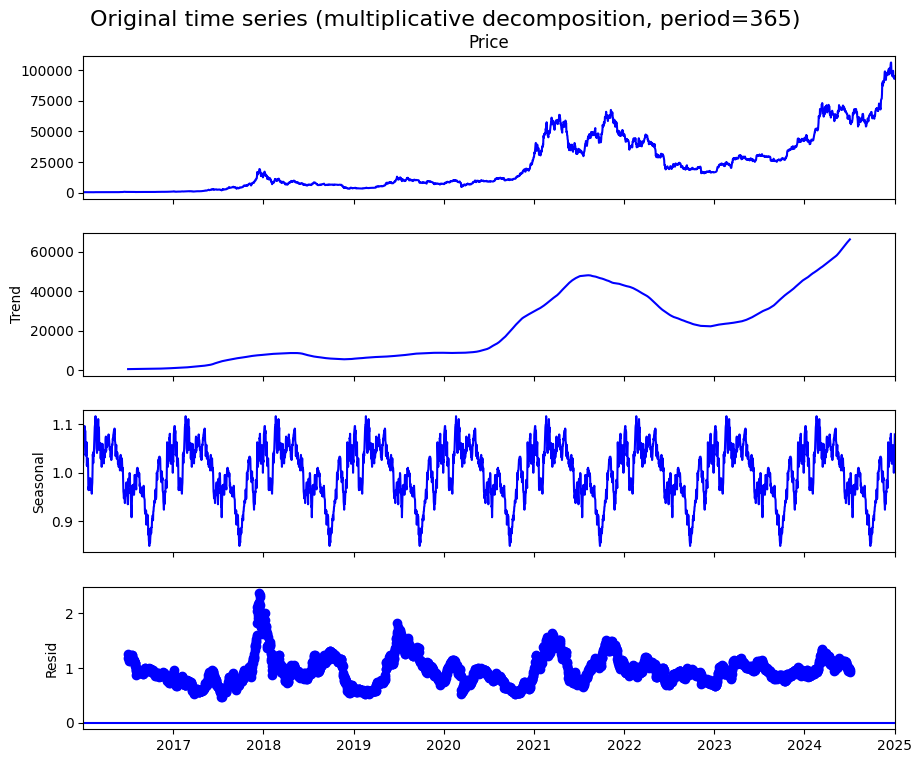

In [654]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=365, title="Original time series (multiplicative decomposition, period=365)", plot_color='blue')

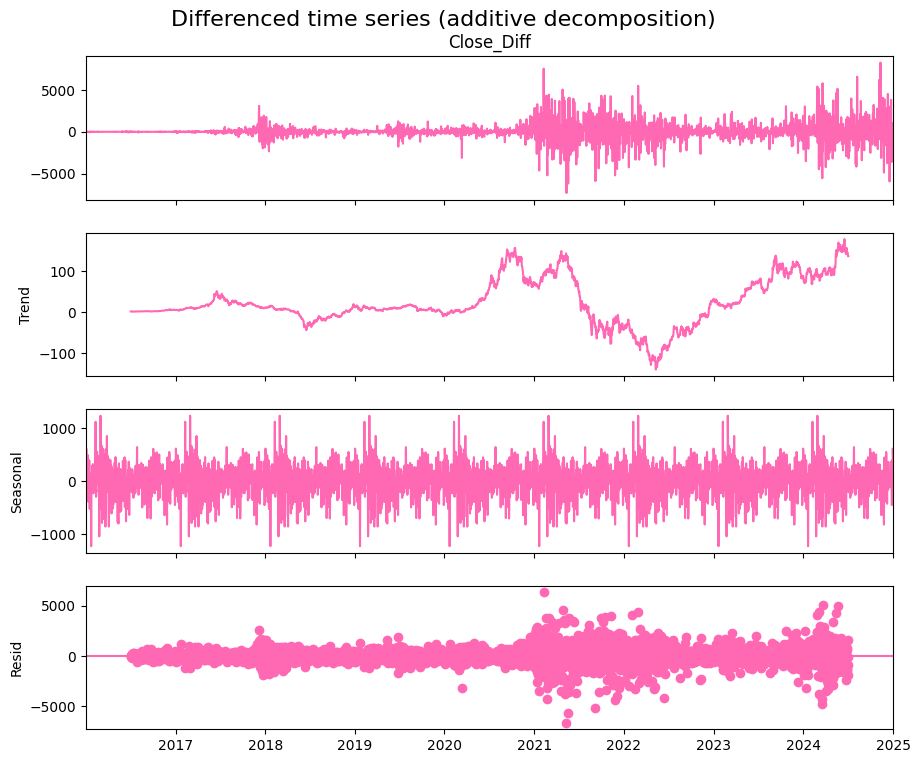

In [32]:
plot_decomposition(bitcoin['Close_Diff'], model='additive',period=365, plot_color='hotpink', title="Differenced time series (additive decomposition)")


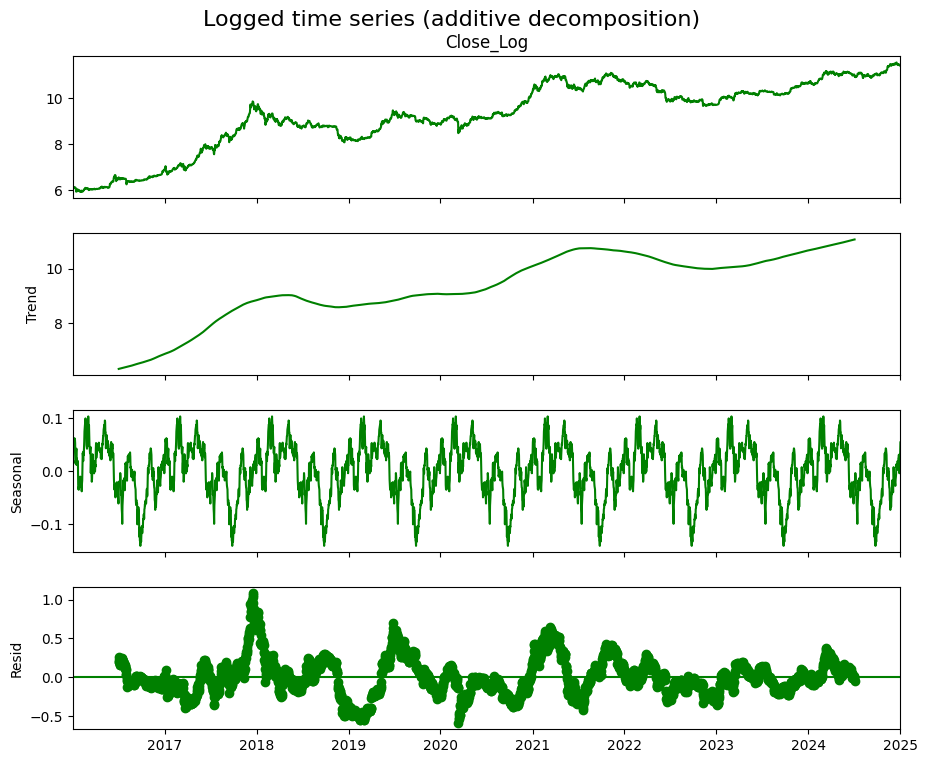

In [33]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=365, title="Logged time series (additive decomposition)", plot_color='green')


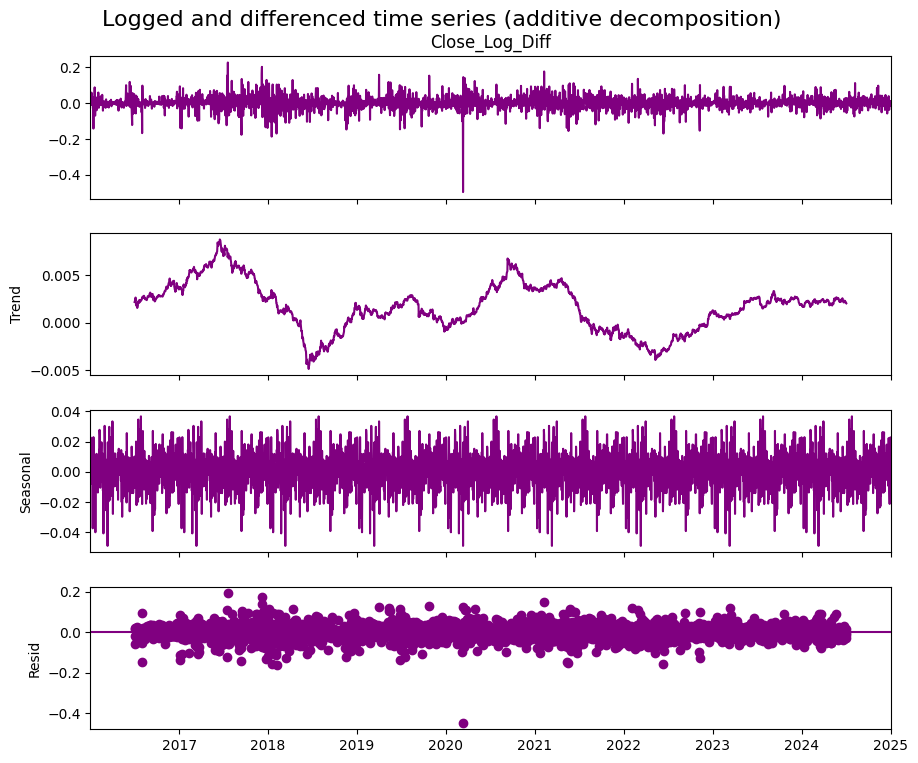

In [34]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=365, title="Logged and differenced time series (additive decomposition)", plot_color='purple')


##### Quarterly

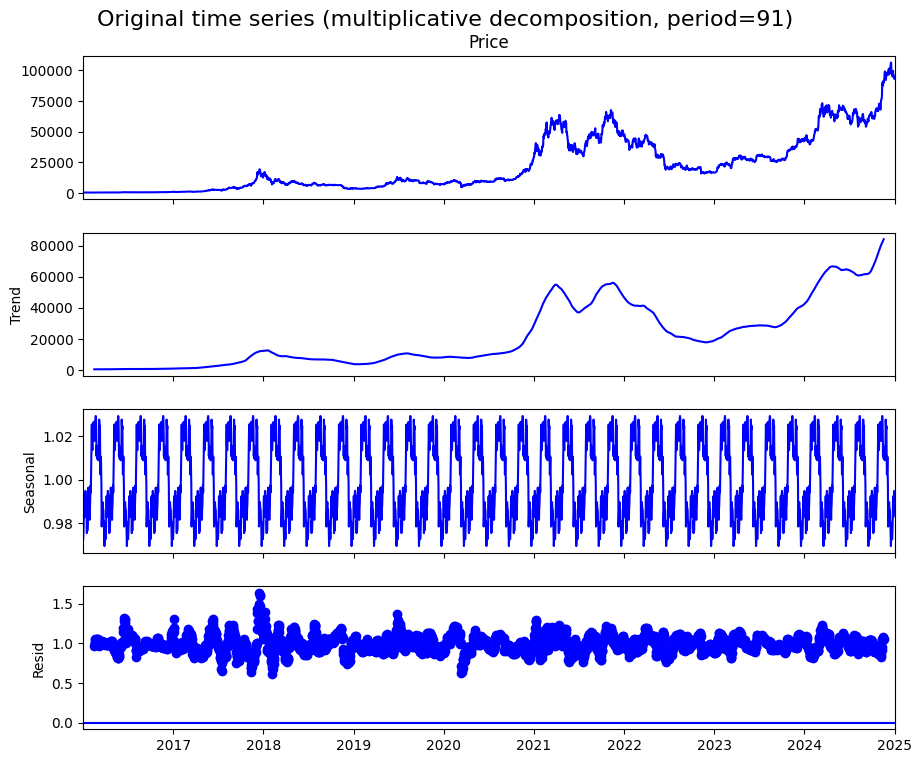

In [35]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=91, title="Original time series (multiplicative decomposition, period=91)", plot_color='blue')


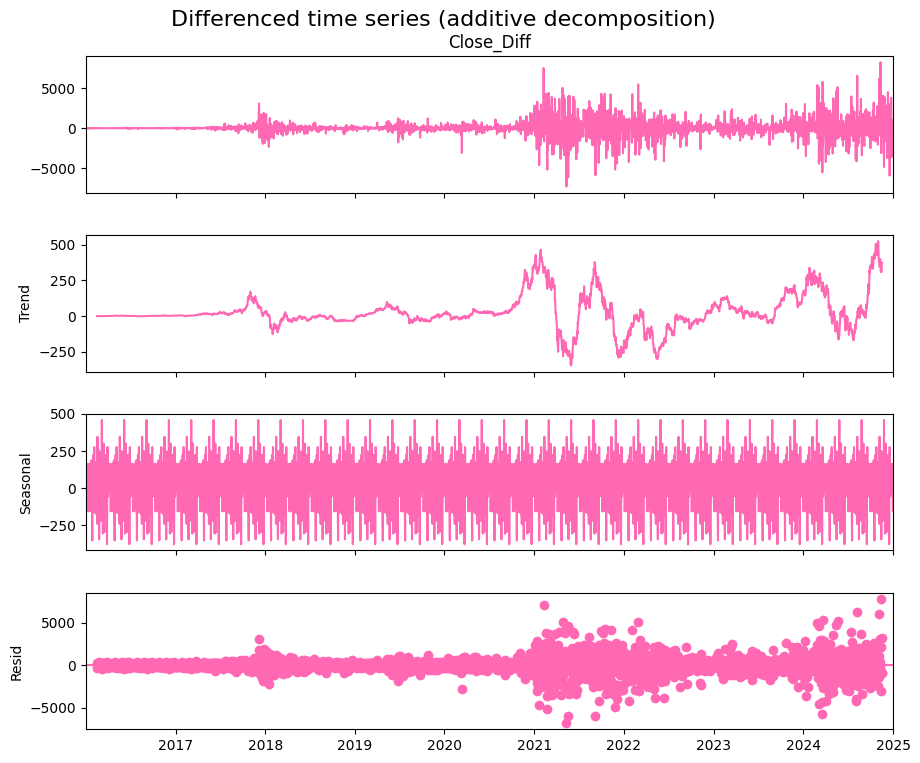

In [36]:
plot_decomposition(bitcoin['Close_Diff'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='hotpink')

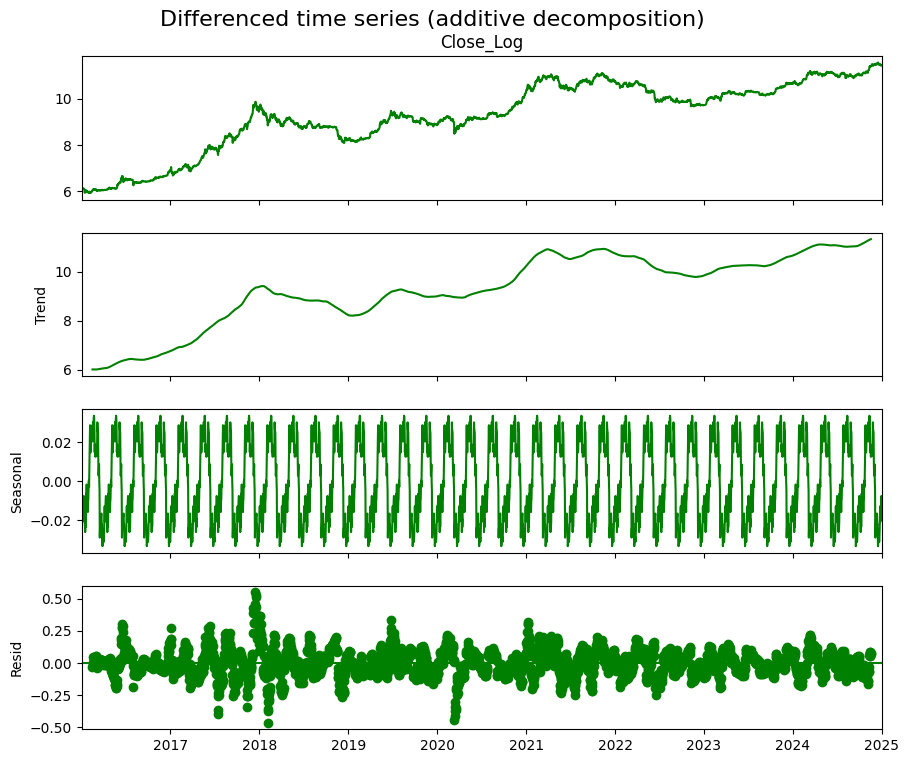

In [37]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='green')

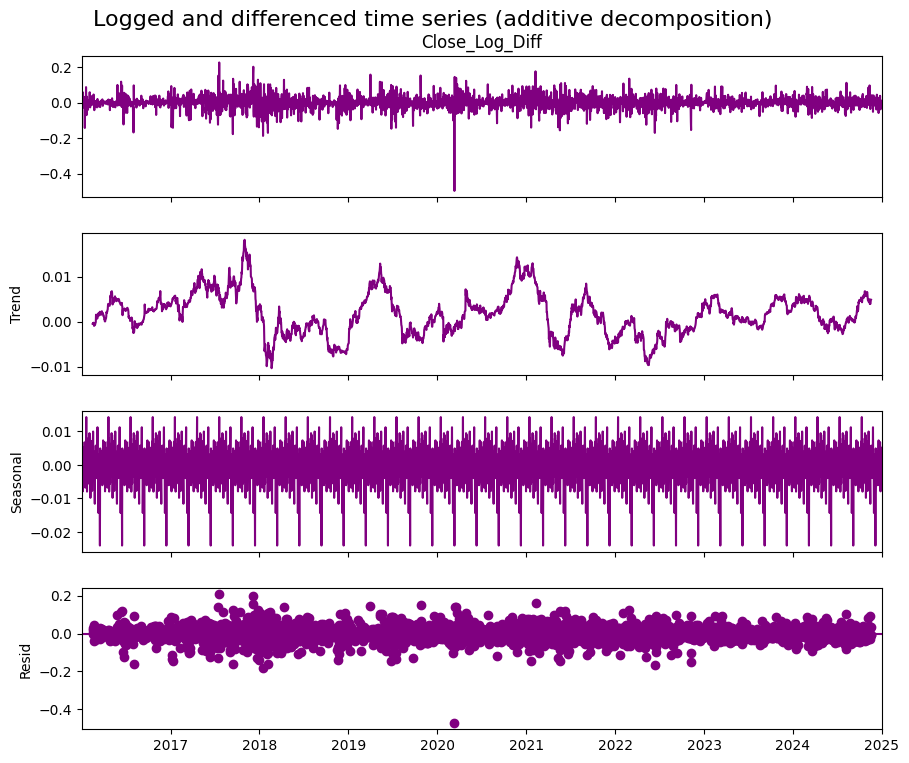

In [38]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=91, title="Logged and differenced time series (additive decomposition)", plot_color='purple')


##### 4-year periods

In [39]:
halving_periods = [
    {'start': '2016-07-09', 'end': '2020-05-11'},  # From first to second halving
    {'start': '2020-05-11', 'end': '2024-04-19'},  # From second to third halving
]

halving_data = []
for period in halving_periods:
    segment = bitcoin[(bitcoin.index >= period['start']) & (bitcoin.index <= period['end'])]
    halving_data.append(segment)

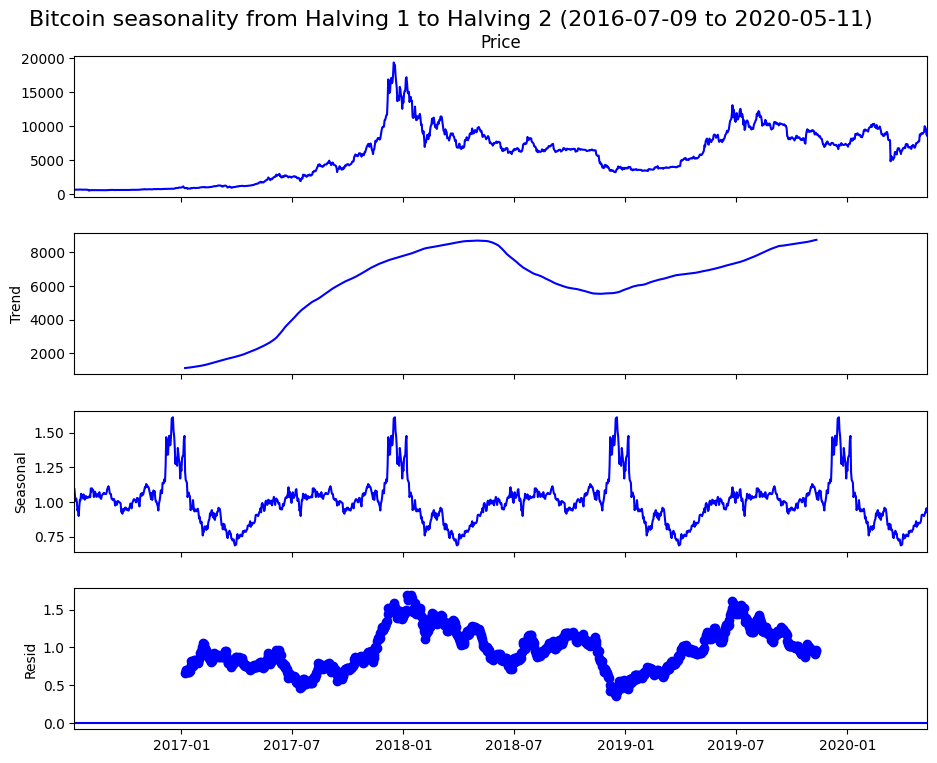

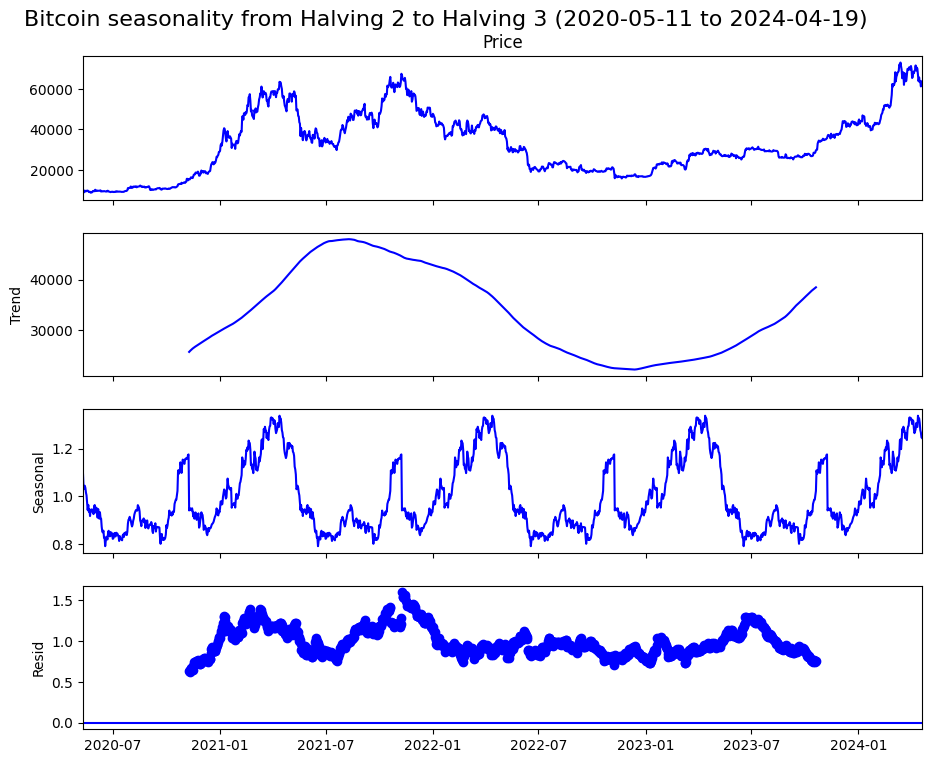

In [40]:
def plot_seasonality_for_period(data, title, period=365, plot_color='blue'):
    plot_decomposition(data['Price'], model='multiplicative', period=period, title=title, plot_color=plot_color)

for i, segment in enumerate(halving_data):
    title = f"Bitcoin seasonality from Halving {i+1} to Halving {i+2} ({segment.index[0].strftime('%Y-%m-%d')} to {segment.index[-1].strftime('%Y-%m-%d')})"
    plot_seasonality_for_period(segment, title=title, plot_color='blue')

#### ACF PACF

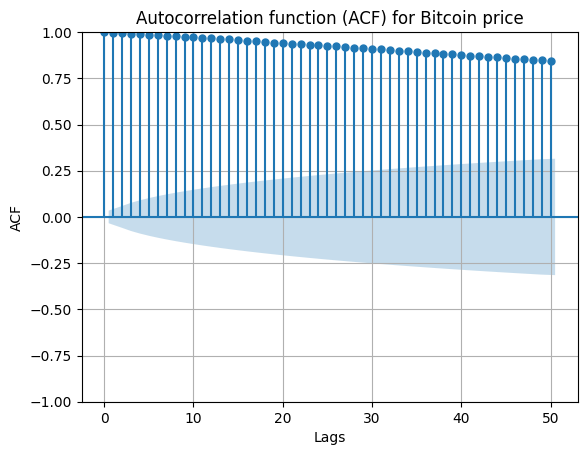

In [41]:
plot_acf(bitcoin['Price'], lags=50)
plt.title('Autocorrelation function (ACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

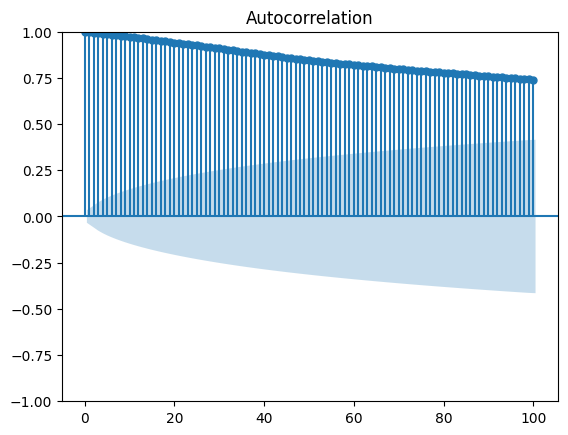

In [42]:
plot_acf(bitcoin['Price'], lags=100)
plt.show()

The Autocorrelation plot for the data is:


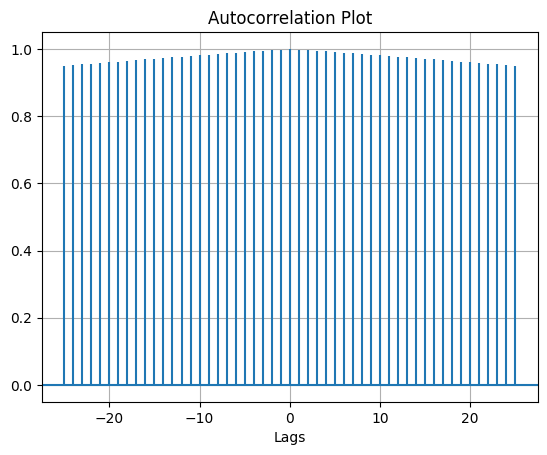

In [43]:
plt.title("Autocorrelation Plot") 
plt.xlabel("Lags") 
plt.acorr(bitcoin["Price"], maxlags = 25) 
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

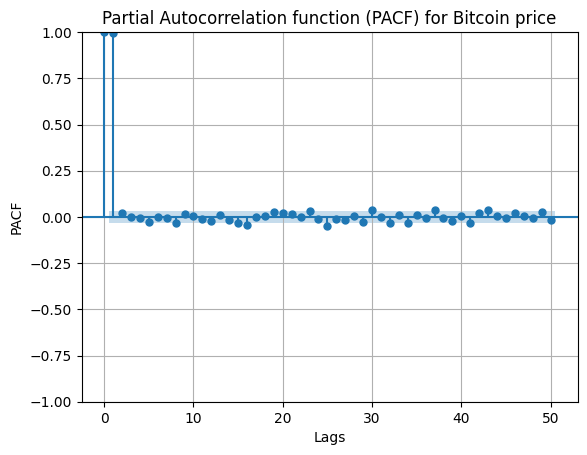

In [44]:
plot_pacf(bitcoin['Price'], lags=50)
plt.title('Partial Autocorrelation function (PACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

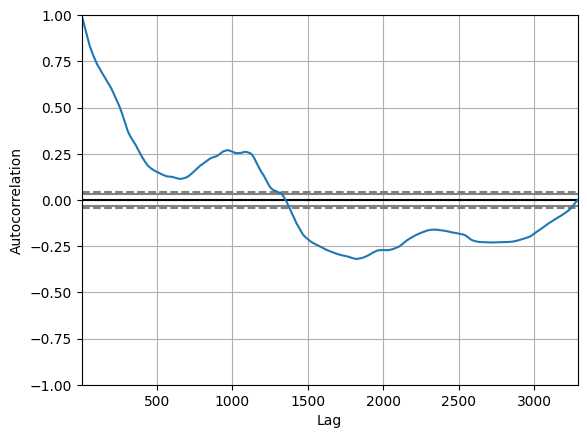

In [45]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(bitcoin['Price'])
plt.show()


In [46]:
from prophet import Prophet

df = bitcoin[['Price']].reset_index()
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df

c:\Users\Wiola\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ds,y
0,2016-01-02,433.7
1,2016-01-03,430.7
2,2016-01-04,433.3
3,2016-01-05,431.2
4,2016-01-06,430.8
...,...,...
3283,2024-12-28,95284.5
3284,2024-12-29,93716.3
3285,2024-12-30,92779.8
3286,2024-12-31,93557.2


In [47]:
df['ds'] = pd.to_datetime(df['ds'])
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 'yhat' represents the predicted values, 'yhat_lower' and 'yhat_upper' are the confidence intervals
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

20:47:32 - cmdstanpy - INFO - Chain [1] start processing
20:47:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2016-01-02,-53.705306,-6208.260499,5847.215513
1,2016-01-03,-87.010155,-6391.122542,5943.762648
2,2016-01-04,-78.128458,-6333.312452,6196.616717
3,2016-01-05,-179.375532,-6637.297749,6142.608808
4,2016-01-06,-173.669986,-6437.456502,6134.624896
...,...,...,...,...
3313,2025-01-27,85890.016499,79607.760401,92154.859913
3314,2025-01-28,85989.799206,79640.494247,92344.632749
3315,2025-01-29,86220.767850,79884.884428,92454.151119
3316,2025-01-30,86300.755330,80143.001001,92216.582972


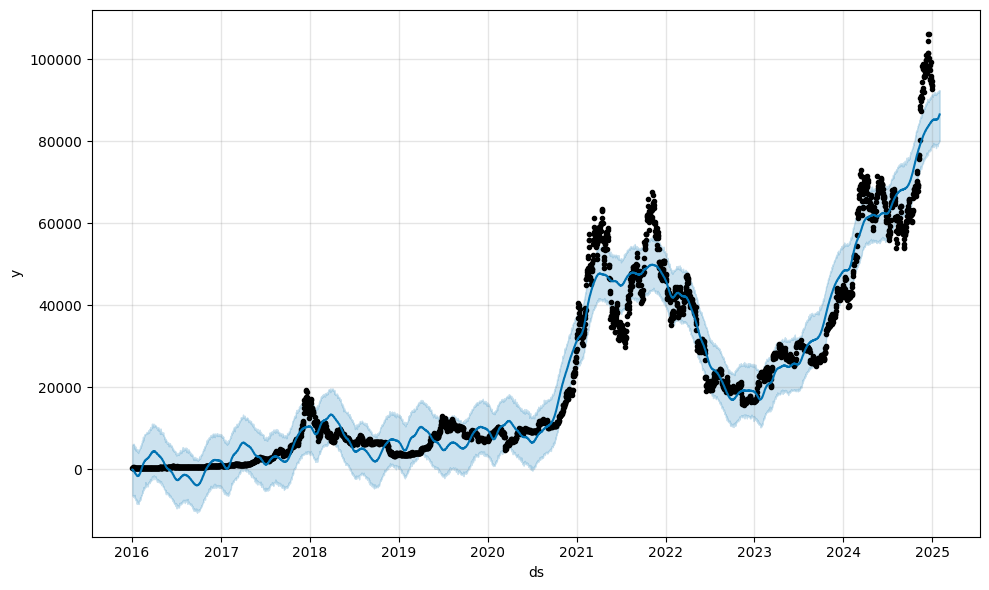

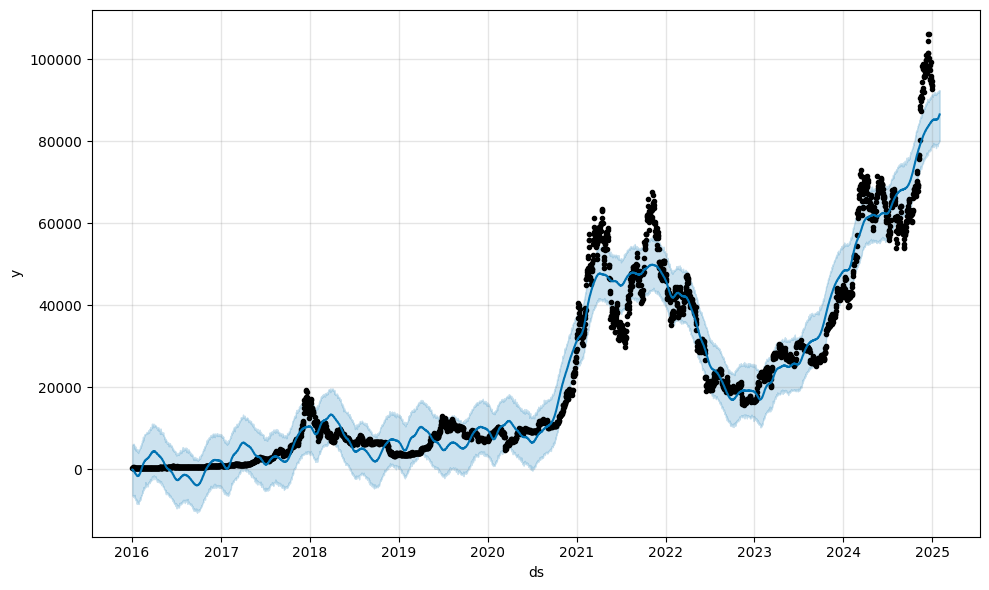

In [48]:
model.plot(forecast)

#### Holt-Winters model

In [49]:
df = bitcoin.copy()
df

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30
Date,,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN,NaN
...,...,...,...,...,...,...
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429,98661.200000
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571,98537.143333
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714,98416.280000


In [50]:
df.drop(columns=['Close_Diff', 'Close_Log', 'Close_Log_Diff', 'SMA_7', 'SMA_30'], inplace=True)
df.head()

,Price
Date,
2016-01-02,433.7
2016-01-03,430.7
2016-01-04,433.3
2016-01-05,431.2
2016-01-06,430.8


In [51]:
train_size = int(len(df) * 0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

In [52]:
hw_model = ExponentialSmoothing(df_train, seasonal='add', seasonal_periods=30, trend='add').fit()


c:\Users\Wiola\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Wiola\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


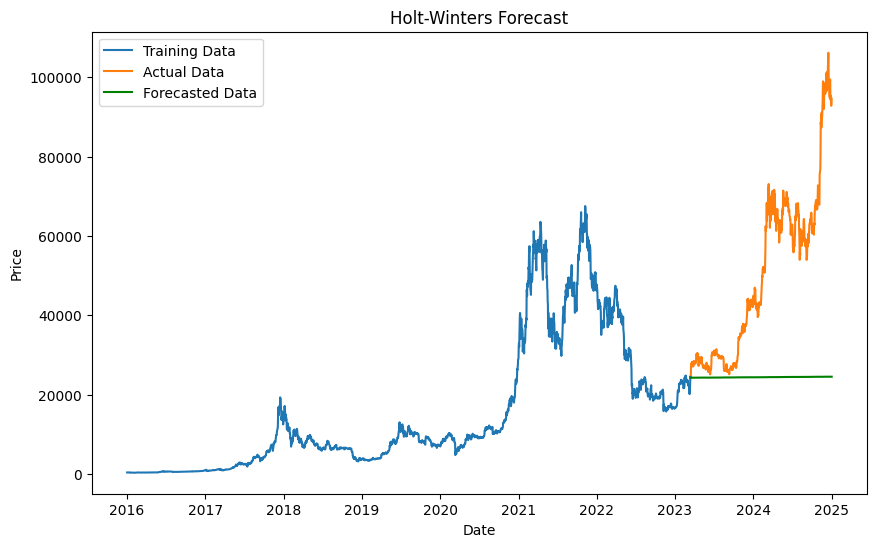

In [53]:
forecast = hw_model.forecast(steps=len(df_test))

plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train, label='Training Data')
plt.plot(df_test.index, df_test, label='Actual Data')
plt.plot(df_test.index, forecast, label='Forecasted Data', color='green')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#### Rolling Forecast ARIMA

In [54]:
df = bitcoin_data.copy()

In [55]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [56]:
price = df['Price']
size = int(len(price) * 0.8)
train, test = price[:size], price[size:]

In [57]:
history = [x for x in train]
predictions = list()

In [58]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))  # Using ARIMA(5,1,0) as an example
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Predicted: {yhat:.2f}, Expected: {obs:.2f}')

# Evaluate the performance using RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')


C:\Users\Wiola\AppData\Local\Temp\ipykernel_14492\3146826395.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


Predicted: 44452.70, Expected: 43521.00
Predicted: 43655.77, Expected: 42388.40
Predicted: 42481.58, Expected: 42205.20
Predicted: 42222.77, Expected: 42061.10
Predicted: 42009.00, Expected: 42550.30
Predicted: 42451.21, Expected: 44544.40
Predicted: 44438.58, Expected: 43883.60
Predicted: 43896.47, Expected: 40552.80
Predicted: 40722.18, Expected: 40000.10
Predicted: 40144.01, Expected: 40090.30
Predicted: 40053.00, Expected: 38355.00
Predicted: 38213.97, Expected: 37017.70
Predicted: 36969.79, Expected: 38248.20
Predicted: 38180.80, Expected: 37224.60
Predicted: 37131.00, Expected: 38339.20
Predicted: 38229.34, Expected: 39209.60
Predicted: 39192.31, Expected: 39115.50
Predicted: 39105.23, Expected: 37689.10
Predicted: 37792.28, Expected: 43188.20
Predicted: 43060.29, Expected: 44420.30
Predicted: 44308.86, Expected: 43912.80
Predicted: 43957.16, Expected: 42463.00
Predicted: 42831.42, Expected: 39142.70
Predicted: 39399.26, Expected: 39395.80
Predicted: 39400.62, Expected: 38403.10


KeyboardInterrupt: 

#### GARCH

In [66]:
data_garch = bitcoin.copy()
data_garch

,Price,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,SMA_30
Date,,,,,,
2016-01-02,433.7,-0.3,6.072353,-0.000691,NaN,NaN
2016-01-03,430.7,-3.0,6.065412,-0.006941,NaN,NaN
2016-01-04,433.3,2.6,6.071430,0.006019,NaN,NaN
2016-01-05,431.2,-2.1,6.066572,-0.004858,NaN,NaN
2016-01-06,430.8,-0.4,6.065644,-0.000928,NaN,NaN
...,...,...,...,...,...,...
2024-12-28,95284.5,1008.6,11.464622,0.010642,96204.771429,98661.200000
2024-12-29,93716.3,-1568.2,11.448027,-0.016595,95995.128571,98537.143333
2024-12-30,92779.8,-936.5,11.437984,-0.010043,95699.085714,98416.280000


In [67]:
data_garch['Returns'] = (np.log(data_garch['Price'] / data_garch['Price'].shift(1))) *100
data_garch.drop(columns=['Price', 'Close_Diff', 'Close_Log', 'Close_Log_Diff', 'SMA_7', 'SMA_30'], inplace=True)
data_garch

,Returns
Date,
2016-01-02,NaN
2016-01-03,-0.694126
2016-01-04,0.601854
2016-01-05,-0.485831
2016-01-06,-0.092807
...,...
2024-12-28,1.064156
2024-12-29,-1.659502
2024-12-30,-1.004319


In [68]:
data_garch.fillna(method='bfill', inplace = True)
data_garch

C:\Users\Wiola\AppData\Local\Temp\ipykernel_14492\2740995523.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_garch.fillna(method='bfill', inplace = True)


,Returns
Date,
2016-01-02,-0.694126
2016-01-03,-0.694126
2016-01-04,0.601854
2016-01-05,-0.485831
2016-01-06,-0.092807
...,...
2024-12-28,1.064156
2024-12-29,-1.659502
2024-12-30,-1.004319


In [95]:
train_size = int(len(data_garch) * 0.8)
g_train, g_test = data_garch.iloc[:train_size], data_garch.iloc[train_size:]

In [99]:
#Finding the best model of GARCH


p_values = [1, 2, 3]
q_values = [1, 2, 3]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q = None, None

for p in p_values:
    for q in q_values:
        try:
            model = arch_model(g_train['Returns'], vol='Garch', p=p, q=q, mean='Constant')
            model_fit = model.fit(disp='off')
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_model = model_fit
                best_p, best_q = p, q

        except Exception as e:
            print(f"Error fitting GARCH({p},{q}): {e}")

print(f"Best Model: GARCH({best_p},{best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: GARCH(1,3)
AIC: 14270.501875056107
BIC: 14305.750309807137


In [97]:
model = arch_model(g_train['Returns'], vol='Garch', p=1, q=3, mean='Constant', dist='normal')
fit = model.fit(disp="off")

horizon = len(g_test['Returns'])
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = g_test['Returns']**2  # Use squared returns as a proxy for realized variance
mse = mean_squared_error(actual_volatility, forecasted_volatility**2)  # Compare variances
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 625.9269058450063


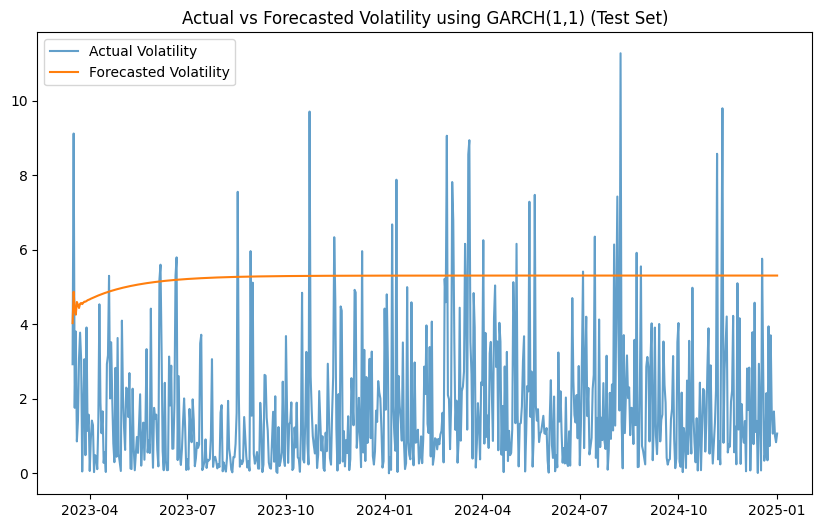

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(g_test.index,  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(g_test.index, forecasted_volatility, label="Forecasted Volatility")
plt.title("Actual vs Forecasted Volatility using GARCH(1,3) (Test Set)")
plt.legend()
plt.show()

#### Rolling forecast GARCH

In [108]:
data_garch

,Returns
Date,
2016-01-02,-0.694126
2016-01-03,-0.694126
2016-01-04,0.601854
2016-01-05,-0.485831
2016-01-06,-0.092807
...,...
2024-12-28,1.064156
2024-12-29,-1.659502
2024-12-30,-1.004319


In [109]:
tstart = "2016-01-02"
tend = "2023-03-15"

In [111]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = data_garch.loc[tstart:tend, "Returns"].values
    test = data_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(data_garch, tstart, tend)


In [112]:
#Rolling forecast
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = data_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

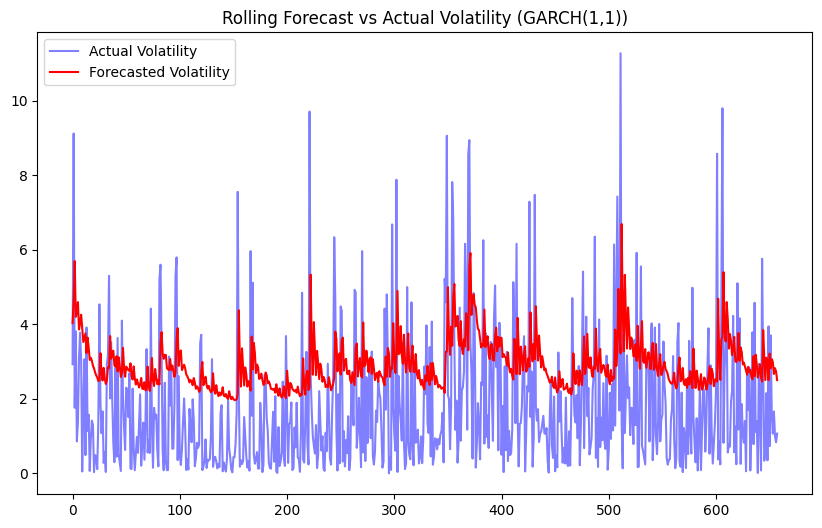

In [ ]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility (GARCH(1,3))")
plt.legend()
plt.show()